In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pept import LineData, Pipeline, PointData
from pept.tracking import Stack, HDBSCAN, Cutpoints, SplitLabels, Centroids, Condition
from scipy.interpolate import interp1d
from skopt import gp_minimize
from skopt.space import Real, Integer
import sys
sys.path.append("/home/rayhaan/randomWalk_V3/Scripts/")
from interpolateTime import interpolateUnique
from tqdm import tqdm
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib widget

In [2]:
def errorCalculation(truePath: PointData, trackedPath: PointData) -> np.float64:
    fx = interp1d(truePath['t'], truePath['x'], fill_value = "extrapolate")
    fy = interp1d(truePath['t'], truePath['y'], fill_value = "extrapolate")
    fz = interp1d(truePath['t'], truePath['z'], fill_value = "extrapolate")

    xInterp = fx(trackedPath['t'])
    yInterp = fy(trackedPath['t'])
    zInterp = fz(trackedPath['t'])

    errorX = np.sum(np.abs(xInterp - trackedPath['x']))/len(xInterp)
    errorY = np.sum(np.abs(yInterp - trackedPath['y']))/len(xInterp)
    errorZ = np.sum(np.abs(zInterp - trackedPath['z']))/len(xInterp)

    combinedError = np.sqrt(errorX**2 + errorY**2 + errorZ**2)

    return combinedError

In [3]:
def loadTruePath(path: str) -> PointData:
    data = np.loadtxt(path, skiprows = 3)
    points = np.array([data[:, 0], data[:, 5], data[:, 6], data[:, 7]]).T
    pData = PointData(points)
    return pData

def loadData(path: str) -> LineData:
    lines = np.load(path)
    rawLines = np.array([lines[:, 6], lines[:, 0], lines[:, 1], lines[:, 2], lines[:, 3], lines[:, 4], lines[:, 5]]).T
    lData = LineData(rawLines)
    return lData

In [35]:
trueData = loadTruePath(path = "/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_2.0mm_Varying_Tau_0.08_1.20ms/Placements/RW3_TS_1.20ms_SS_2.00mm.placements")
lors = loadData(path = "/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_2.0mm_Varying_Tau_0.08_1.20ms/Lines_NPY/RW3_TS_1.20ms_SS_2.00mm.npy")

In [36]:
times = lors['t']
newTime = interpolateUnique(msTime = times)
lors_2 = LineData(np.c_[newTime, lors.lines[:, 1:7]])

In [38]:
MLPipe = Pipeline([
            Stack(sample_size = 400, overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = 0.1),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = 0.6),
            SplitLabels() + Centroids(),
            Stack()
        ])

In [39]:
locTest = MLPipe.fit(lors_2)
print("The location rate is {} Hz".format(len(locTest.points)/0.5))

Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 5924.61it/s]



Processed samples in 21.80978488922119 s

The location rate is 760.0 Hz


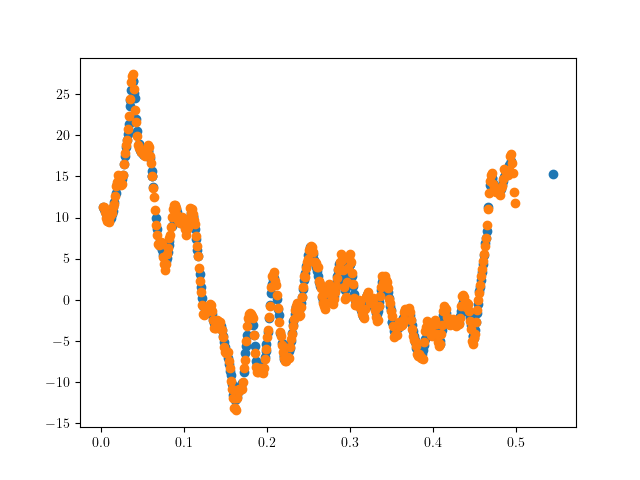

In [40]:
plt.close("all")
fig, ax = plt.subplots(1, 1)
ax.scatter(locTest['t'], locTest['x'])
ax.scatter(trueData['t'], trueData['x'])



In [33]:
# filter2 = Condition("t >= 0.0, t <= 0.5") + Stack()
# locTest2 = filter2.fit(locTest)a

In [59]:
# np.save("/home/rayhaan/randomWalk_V3/Plots/truePath", arr = trueData.points)

In [390]:
# plt.close("all")
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (7, 5), sharex = "col")

# fig.suptitle("TS_0.4ms_Lambda_2.0mm_L_245.954kHz")
# ax1.scatter(locTest2['t'], locTest2['x'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax1.plot(trueData['t'], trueData['x'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax2.scatter(locTest2['t'], locTest2['y'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax2.plot(trueData['t'], trueData['y'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax3.scatter(locTest2['t'], locTest2['z'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax3.plot(trueData['t'], trueData['z'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax1.legend()
# ax2.legend()
# ax3.legend()

# ax3.set_xlabel("t (s)")

# ax1.set_ylabel("X (mm)")
# ax2.set_ylabel("Y (mm)")
# ax3.set_ylabel("Z (mm)")

# fig.tight_layout()
# fig.savefig("/home/rayhaan/randomWalk_V3/Plots/Test_Extreme_OL1.png", dpi = 300)




In [41]:
def optAllML(lowerLocRate, upperLocRate, Data, truePath):

    # out = []

# for i in tqdm(range(len(UsedSampleSizes)-1)):
    def ObjectiveML(x):
        MLPipe = Pipeline([
            Stack(sample_size = x[0], overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = x[1]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = x[2]),
            SplitLabels() + Centroids(),
            Stack()
        ])

        locs = MLPipe.fit(Data, verbose = True)

        locRate = len(locs.points)/0.5

        error = errorCalculation(truePath = truePath, trackedPath = locs)

        if (locRate >= lowerLocRate) and (locRate <= upperLocRate):
            error = error
        else:
            error = 10000 + error

        print("The error is: {} mm, the location rate is: {} kHz".format(error, locRate))

        return error

    space = [   Integer(390, 410, name = 'SS1'),
                # Real(1.0, 3.0, name = 'MD'),
                Real(0.1, 0.6, name = 'TF1'),
                Real(0.55, 0.65, name = 'TF2'),
                    ]

    res = gp_minimize(ObjectiveML, space, n_calls = 20, verbose = True, random_state = 657333)

    out1 = [res.fun, res.x[0], res.x[1], res.x[2]]

    return out1

In [42]:
1/(1.20e-3)

833.3333333333334

In [43]:
lowerLocRate = 790
upperLocRate = 870


In [44]:
optVals = optAllML(lowerLocRate = lowerLocRate, upperLocRate = upperLocRate, Data = lors_2, truePath = trueData)

Iteration No: 1 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 393/393 [00:00<00:00, 5646.45it/s]



Processed samples in 41.618202447891235 s

The error is: 10000.557998925891 mm, the location rate is: 780.0 kHz
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 41.6223
Function value obtained: 10000.5580
Current minimum: 10000.5580
Iteration No: 2 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 4598.49it/s]



Processed samples in 170.33193850517273 s

The error is: 10000.813817343887 mm, the location rate is: 584.0 kHz
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 170.3370
Function value obtained: 10000.8138
Current minimum: 10000.5580
Iteration No: 3 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 393/393 [00:00<00:00, 1643.45it/s]



Processed samples in 24.886276245117188 s

The error is: 10000.3964091916 mm, the location rate is: 72.0 kHz
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 24.8911
Function value obtained: 10000.3964
Current minimum: 10000.3964
Iteration No: 4 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 6177.08it/s]



Processed samples in 22.534693956375122 s

The error is: 10000.426803658893 mm, the location rate is: 62.0 kHz
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 22.5387
Function value obtained: 10000.4268
Current minimum: 10000.3964
Iteration No: 5 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 5281.24it/s]



Processed samples in 137.30835223197937 s

The error is: 10000.395416077004 mm, the location rate is: 48.0 kHz
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 137.3138
Function value obtained: 10000.3954
Current minimum: 10000.3954
Iteration No: 6 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:00<00:00, 5990.62it/s]



Processed samples in 28.304774045944214 s

The error is: 10000.399789636504 mm, the location rate is: 58.0 kHz
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 28.3102
Function value obtained: 10000.3998
Current minimum: 10000.3954
Iteration No: 7 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 402/402 [00:00<00:00, 6014.07it/s]



Processed samples in 99.75398421287537 s

The error is: 0.5636765059317471 mm, the location rate is: 794.0 kHz
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 99.7587
Function value obtained: 0.5637
Current minimum: 0.5637
Iteration No: 8 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 383/383 [00:00<00:00, 5442.90it/s]



Processed samples in 149.1460165977478 s

The error is: 10000.366911076313 mm, the location rate is: 54.0 kHz
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 149.1515
Function value obtained: 10000.3669
Current minimum: 0.5637
Iteration No: 9 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 5892.83it/s]



Processed samples in 154.66767573356628 s

The error is: 10000.430452894401 mm, the location rate is: 60.0 kHz
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 154.6722
Function value obtained: 10000.4305
Current minimum: 0.5637
Iteration No: 10 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 5295.33it/s]



Processed samples in 143.14831733703613 s

The error is: 10000.368686839172 mm, the location rate is: 70.0 kHz
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 143.5544
Function value obtained: 10000.3687
Current minimum: 0.5637
Iteration No: 11 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:00<00:00, 4688.03it/s]



Processed samples in 86.88988590240479 s

The error is: 10000.543326894922 mm, the location rate is: 782.0 kHz
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 87.2734
Function value obtained: 10000.5433
Current minimum: 0.5637
Iteration No: 12 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 7237.00it/s]



Processed samples in 99.23164391517639 s

The error is: 0.5699133673731004 mm, the location rate is: 790.0 kHz
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 99.6037
Function value obtained: 0.5699
Current minimum: 0.5637
Iteration No: 13 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 6271.25it/s]



Processed samples in 99.33625769615173 s

The error is: 0.5673181348829704 mm, the location rate is: 796.0 kHz
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 99.7230
Function value obtained: 0.5673
Current minimum: 0.5637
Iteration No: 14 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 392/392 [00:00<00:00, 4380.79it/s]



Processed samples in 99.63949847221375 s

The error is: 10000.579049197364 mm, the location rate is: 776.0 kHz
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 100.0373
Function value obtained: 10000.5790
Current minimum: 0.5637
Iteration No: 15 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:00<00:00, 4942.80it/s]



Processed samples in 101.49381923675537 s

The error is: 0.528228746475804 mm, the location rate is: 794.0 kHz
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 101.8251
Function value obtained: 0.5282
Current minimum: 0.5282
Iteration No: 16 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [00:00<00:00, 5530.95it/s]



Processed samples in 97.56982135772705 s

The error is: 0.5096513507244409 mm, the location rate is: 812.0 kHz
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 98.0162
Function value obtained: 0.5097
Current minimum: 0.5097
Iteration No: 17 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 394/394 [00:00<00:00, 6133.43it/s]



Processed samples in 100.83467388153076 s

The error is: 10000.565494553599 mm, the location rate is: 774.0 kHz
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 101.1280
Function value obtained: 10000.5655
Current minimum: 0.5097
Iteration No: 18 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 397/397 [00:00<00:00, 4774.74it/s]



Processed samples in 89.2147421836853 s

The error is: 10000.56676269819 mm, the location rate is: 782.0 kHz
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 89.4893
Function value obtained: 10000.5668
Current minimum: 0.5097
Iteration No: 19 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:00<00:00, 7390.76it/s]



Processed samples in 97.61060667037964 s

The error is: 0.536928439969044 mm, the location rate is: 792.0 kHz
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 97.8798
Function value obtained: 0.5369
Current minimum: 0.5097
Iteration No: 20 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 7735.42it/s]



Processed samples in 96.04413914680481 s

The error is: 10000.330171436382 mm, the location rate is: 74.0 kHz
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 96.6182
Function value obtained: 10000.3302
Current minimum: 0.5097


In [46]:
optVals

[0.5096513507244409, 391, 0.3904985535568676, 0.6013199744179751]

In [47]:
MLPipeOpt = Pipeline([
            Stack(sample_size = optVals[1], overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = optVals[2]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = optVals[3]),
            SplitLabels() + Centroids(),
            Stack()
        ])

In [48]:
optLocs = MLPipeOpt.fit(lors_2)
print("The location rate is {:.2f} Hz".format(len(optLocs.points)/0.5))

Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 396/396 [00:00<00:00, 6060.51it/s]



Processed samples in 97.9363009929657 s

The location rate is 778.00 Hz


In [49]:
optLocs

pept.PointData (samples: 396)
-----------------------------
sample_size = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
overlap = None
points = 
  (rows: 389, columns: 4)
  [[ 2.13096172e-03  1.12665495e+01  1.19918733e+01  1.19584307e+01]
  

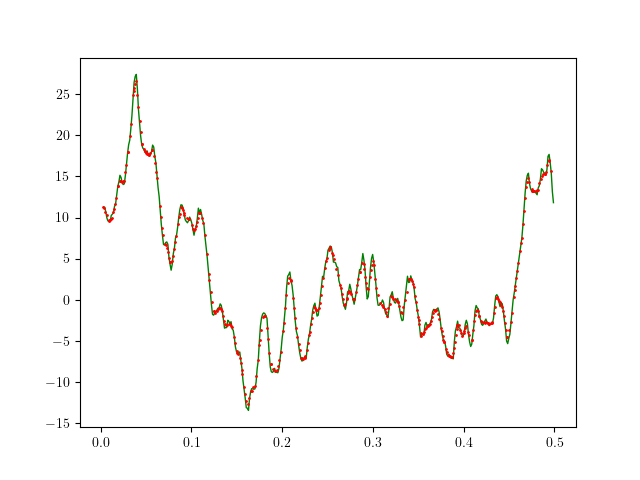

In [50]:
plt.close("all")
fig, ax = plt.subplots(1, 1)

ax.scatter(optLocs['t'], optLocs['x'], color = 'r', s = 1, zorder = 1)
ax.plot(trueData['t'], trueData['x'], color = 'g', lw = 1, zorder = 0)

In [51]:
filter1 = Condition("t >= 0.0, t <= 0.5") + Stack()
filteredLocs = filter1.fit(optLocs)

Batch 1 / 1 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 396/396 [00:00<00:00, 6105.27it/s]



Processed samples in 0.4071834087371826 s



In [52]:
np.save("/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_2.0mm_Varying_Tau_0.08_1.20ms/Tracks/RW3_TS_1.20ms_SS_2.00mm", arr = filteredLocs.points)

In [53]:
uncertainty = errorCalculation(truePath = trueData, trackedPath = optLocs)

In [54]:
print("The uncertainty is {} mm".format(uncertainty))

The uncertainty is 0.5466717118249785 mm


In [5]:
optimVals = np.loadtxt("/home/rayhaan/randomWalk_V3/Notebooks/opt_Sigma_2.0mm.csv", skiprows = 2, delimiter = ", ")

In [6]:
taus = optimVals[:, 0]
deltaR = optimVals[:, 4]

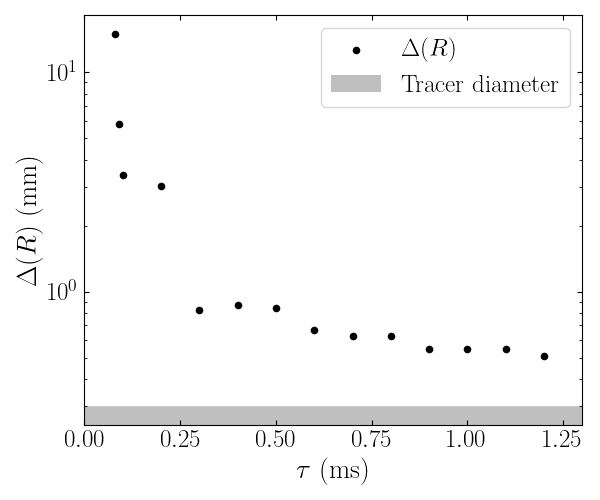

In [29]:
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize = (6, 5))
s = 20


fillx = np.linspace(0.0, 1.3, 1000)
filly = np.repeat(0.3, len(fillx))

ax.scatter(taus, deltaR, s = 20, color = 'k', label = r"$\Delta(R)$")
ax.fill_between(fillx, filly,  facecolor = 'k', alpha = 0.25, label = r"Tracer diameter", edgecolor = "None")

ax.set_xlabel(r"$\tau$ (ms)", fontsize = s)
ax.set_ylabel(r"$\Delta(R)$ (mm)", fontsize = s)

ax.get_xaxis().set_tick_params(direction = "in", which = "both", top = True)
ax.get_yaxis().set_tick_params(direction = "in", which = "both", right = True)

ax.legend(loc = "upper right", fontsize = s - 2)

ax.tick_params(axis="x", labelsize = s - 2) 
ax.tick_params(axis="y", labelsize = s - 2)
ax.set_yscale("log")

ax.set_xlim(0.0, 1.3)
# ax.set_ylim(0.0, 16)
fig.tight_layout()

fig.savefig("/home/rayhaan/randomWalk_V3/Plots/tau_deltaR_Lambda_2.0mm.png", dpi = 300)